In [1]:
import pandas as pd
import numpy as np
import nltk

In [2]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [4]:
#!pip install wordcloud

You are using pip version 18.1, however version 19.0.2 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [3]:
imdb = pd.read_csv('https://raw.githubusercontent.com/skathirmani/datasets/master/imdb_sentiment.csv')

In [4]:
imdb.head()

,review,sentiment
0,"A very, very, very slow-moving, aimless movie ...",0
1,Not sure who was more lost - the flat characte...,0
2,Attempting artiness with black & white and cle...,0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo i...,1


In [5]:
imdb['sentiment'].value_counts()

1    386
0    362
Name: sentiment, dtype: int64

Bag of Words Analysis
-----------------

In [6]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

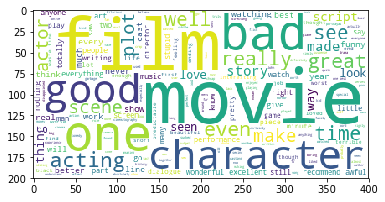

In [45]:
input_string = ' '.join(imdb['review'])
wc = WordCloud(background_color = 'white').generate(input_string)
plt.imshow(wc)

In [49]:
#for x,y in wc.words_.items():
#    print(x,y)
#print([(key,value) for key ,value in sorted(wc.words_.items(),key = lambda x:x[1],reverse = True)][0:10]) 
sorted(wc.words_.items(),key = lambda x:x[1],reverse = True)[0:10]

[('movie', 1.0),
 ('film', 0.8815165876777251),
 ('one', 0.3459715639810427),
 ('bad', 0.33649289099526064),
 ('character', 0.2796208530805687),
 ('good', 0.27488151658767773),
 ('acting', 0.2037914691943128),
 ('really', 0.1943127962085308),
 ('great', 0.1943127962085308),
 ('even', 0.1895734597156398)]

## Text Cleaning
- Convert every character to lower case
- Remove junk characters
- Remove commonly used words
- Identify root of the words

In [7]:
docs = imdb['review'].str.lower().str.replace('[^a-z ]','')

In [8]:
stopwords = nltk.corpus.stopwords.words('english')
len(stopwords)
#stopwords[:5]

179

In [9]:
stemmer = nltk.stem.PorterStemmer()
stemmer.stem('organization')

'organ'

In [10]:
docs_clean = []
for doc in docs.head(2):
    words = doc.split(' ')
    #print(doc)
    #print(words)
    word_clean = []
    for word in words:
        if word not in stopwords:
            word_clean.append(stemmer.stem(word))
    doc_clean = ' '.join(word_clean)
    docs_clean.append(doc_clean)
print(docs_clean)

['slowmov aimless movi distress drift young man  ', 'sure lost  flat charact audienc nearli half walk  ']


In [11]:
docs = imdb['review'].str.lower().str.replace('[^a-z ]','')

def clean_sentence(text):
    words = text.split(' ')
    words_clean = [stemmer.stem(word) for word in words if word not in stopwords]
    return ' '.join(words_clean)
docs_clean = docs.apply(clean_sentence)
docs_clean.head()

0      slowmov aimless movi distress drift young man  
1    sure lost  flat charact audienc nearli half wa...
2    attempt arti black  white clever camera angl m...
3                            littl music anyth speak  
4    best scene movi gerardo tri find song keep run...
Name: review, dtype: object

Sparsity = No. of zeroes / ( No. of Rows * No. of Columns)
------

## Document Term Matrix

In [12]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectorizer.fit(docs_clean)
dtm = vectorizer.transform(docs_clean)
dtm

<748x2475 sparse matrix of type '<class 'numpy.int64'>'
	with 6797 stored elements in Compressed Sparse Row format>

In [13]:
docs_clean.shape

(748,)

In [14]:
no_of_zeroes = (748*2475) - 6797
sparsity = no_of_zeroes / (748*2475) * 100
sparsity

99.63285259007183

In [15]:
df_dtm = pd.DataFrame(dtm.toarray(),
                     columns = vectorizer.get_feature_names())
df_dtm.head()

,aailiyah,abandon,abil,abroad,absolut,abstrus,abysm,academi,accent,access,...,younger,your,youth,youtub,youv,yun,zillion,zombi,zombiestud,zombiez
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
(df_dtm == 0).sum().sum()

1844503

In [17]:
df_dtm.sum().sort_values(ascending=False).head(2)

movi    207
film    184
dtype: int64

In [18]:
df_dtm.sum(axis=1).sort_values(ascending=False).head(10)

136    686
19     425
646    408
149    131
135    107
422     41
192     37
223     34
271     31
230     29
dtype: int64

In [19]:
from sklearn.model_selection import train_test_split
train_x, test_x = train_test_split(df_dtm,
                                  test_size = 0.2,
                                  random_state = 100)

In [20]:
train_y = imdb.iloc[train_x.index]['sentiment']
test_y = imdb.iloc[test_x.index]['sentiment']

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
rf_model = RandomForestClassifier(random_state = 100, n_estimators = 300)
rf_model.fit(train_x, train_y)
rf_predict_class = rf_model.predict(test_x)
accuracy_score(test_y,rf_predict_class)

0.72

In [24]:
from sklearn.naive_bayes import GaussianNB
gnb_model = GaussianNB()
gnb_model.fit(train_x, train_y)
gnb_predict_class = gnb_model.predict(test_x)
accuracy_score(test_y,gnb_predict_class)

0.5933333333333334

In [23]:
from sklearn.naive_bayes import MultinomialNB
mnb_model = MultinomialNB()
mnb_model.fit(train_x, train_y)
mnb_predict_class = mnb_model.predict(test_x)
accuracy_score(test_y,mnb_predict_class)

0.7733333333333333

TF-IDF Vectorization
--------------

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer

train, test = train_test_split(docs_clean, test_size = 0.2, random_state = 100) 
tfidf = TfidfVectorizer() 
tfidf.fit(train) 
train_dtm_tfidf = tfidf.transform(train) 
test_dtm_tfidf = tfidf.transform(test) 

df_train_tfidf = pd.DataFrame(train_dtm_tfidf.toarray(), columns = tfidf.get_feature_names()) 
df_test_tfidf = pd.DataFrame(test_dtm_tfidf.toarray(), columns = tfidf.get_feature_names()) 

train_y = imdb.iloc[df_train_tfidf.index]['sentiment'] 
test_y = imdb.iloc[df_test_tfidf.index]['sentiment'] 
rf_model = RandomForestClassifier(random_state = 100, n_estimators = 300) 
rf_model.fit(df_train_tfidf, train_y) 
rf_predict_class = rf_model.predict(df_test_tfidf) 
accuracy_score(test_y, rf_predict_class) 

0.4866666666666667